# Predicting a US presidential election using Bayesian optimal polling

In this tutorial, we explore the use of optimal experimental design techniques to create an optimal polling strategy to predict the outcome of the US presidential election. In a [previous tutorial](working_memory.ipynb), we explored the use of Bayesian optimal experimental design to learn the working memory capacity of a single person. Here, we apply the same concepts to study a whole country.

To begin, we need a Bayesian model of the winner of the election `w`, as well as the outcome `y` of any poll we may plan to conduct. The experimental design is the number of people $n_i$ to poll in each state. To set up our exploratory model, we are going to make a number of simplifying assumptions. We will use historical election data 1976-2012 to construct a plausible prior and the 2016 election as our test set: we imagine that we are conducting polling just before the 2016 election.

## Choosing a prior
In our model, we include a 51 dimensional latent variabe `alpha`. For each of the 50 states plus DC we define 

$$ \alpha_i = \text{logit }\mathbb{P}(\text{a random voter in state } i \text{ votes Democrat in the 2016 election}) $$

and we assume all other voters vote Republican. Right before the election, the value of $\alpha$ is unknown and we wish to estimate it by conducting a poll with $n_i$ people in state $i$ for $i=1, ..., 51$ . The winner $w$ of the election is decided by the Electoral College system. The number of electoral college votes gained by the Democrats in state $i$ is
$$
e_i =  \begin{cases}
k_i \text{ if } \alpha_i > \frac{1}{2} \\
0 \text{ otherwise}
\end{cases}
$$
(this is a rough approximation of the true system). All other electoral college votes go to the Republicans. Here $k_i$ is the number of electoral college votes alloted to state $i$, which are listed in the following data frame.

In [1]:
import pandas as pd
import torch

electoral_college_votes = pd.read_pickle("electoral_college_votes.pickle")
print(electoral_college_votes.head())
ec_votes_tensor = torch.tensor(electoral_college_votes.values, dtype=torch.float).squeeze()

       Electoral college votes
State                         
AL                           9
AK                           3
AZ                          11
AR                           6
CA                          55


The winner $w$ of the election is

$$ w = \begin{cases}
\text{Democrats if } \sum_i e_i > \frac{1}{2}\sum_i k_i  \\
\text{Republicans otherwise}
\end{cases}
$$

In code, this is expressed as follows

In [2]:
def election_winner(alpha):
    dem_win_state = (alpha > 0.).float()
    dem_electoral_college_votes = ec_votes_tensor * dem_win_state
    w = (dem_electoral_college_votes.sum(-1) / ec_votes_tensor.sum(-1) > .5).float()
    return w

We are interested in polling strategies that will help us predict $w$, rather than predicting the more complex state-by-state results $\alpha$.

To set up a fully Bayesian model, we need a prior for $\alpha$. We will base the prior on the outcome of some historical presidential elections. Specifically, we'll use the following dataset of state-by-state election results for the presidential elections 1976-2012 inclusive. Note that votes for parties other than Democrats and Republicans have been ignored.

In [3]:
frame = pd.read_pickle("us_presidential_election_data_historical.pickle")
print(frame[[1976, 1980, 1984]].head())

          1976                1980                1984           
      Democrat Republican Democrat Republican Democrat Republican
State                                                            
AL      659170     504070   636730     654192   551899     872849
AK       44058      71555    41842      86112    62007     138377
AZ      295602     418642   246843     529688   333854     681416
AR      499614     268753   398041     403164   338646     534774
CA     3742284    3882244  3083661    4524858  3922519    5467009


Based on this data alone, we will base our prior mean for $\alpha$ solely on the 2012 election. Our model will be based on logistic regression, so we will transform the probability of voting Democrat using the logit function. Specifically, we'll choose a prior mean as follows:

In [4]:
results_2012 = torch.tensor(frame[2012].values, dtype=torch.float)
prior_mean = torch.log(results_2012[..., 0] / results_2012[..., 1])

Our prior distribution for $\alpha$ will be a multivariate Normal with mean `prior_mean`. The only thing left to decide upon is the covariance matrix. Since `alpha` values are logit-transformed, the covariance will be defined in logit space as well.

*Aside*: The prior covariance is important in a number of ways. If we allow too much variance, the prior will be uncertain about the outcome in every state, and require polling everywhere. If we allow too little variance, we may be caught off-guard by an unexpected electoral outcome. If we assume states are independent, then we will not be able to pool information across states; but assume too much correlation and we could too faithfully base predictions about one state from poll results in another.

We select the prior covariance by taking the empirical covariance from the elections 1976 - 2012 and adding a small value `0.01` to the diagonal.

In [5]:
idx = 2 * torch.arange(10)
as_tensor = torch.tensor(frame.values, dtype=torch.float)
logits = torch.log(as_tensor[..., idx] / as_tensor[..., idx + 1]).transpose(0, 1)
mean = logits.mean(0)
sample_covariance = (1/(logits.shape[0] - 1)) * (
    (logits.unsqueeze(-1) - mean) * (logits.unsqueeze(-2) - mean)
).sum(0)
prior_covariance = sample_covariance + 0.01 * torch.eye(sample_covariance.shape[0])

## Setting up the model
We are now in a position to define our model. At a high-level the model works as follows:
 - $\alpha$ is multivariate Normal
 - $w$ is a deterministic function of $\alpha$
 - $y_i$ is Binomial($n_i$, sigmoid($\alpha_i$)) so we are assuming that people respond to the poll in exactly the same way that they will vote on election day
 
In Pyro, this model looks as follows

In [6]:
import pyro
import pyro.distributions as dist

def model(polling_allocation):
    # This allows us to run many copies of the model in parallel
    with pyro.plate_stack("plate_stack", polling_allocation.shape[:-1]):
        # Begin by sampling alpha
        alpha = pyro.sample("alpha", dist.MultivariateNormal(
            prior_mean, covariance_matrix=prior_covariance))
        
        # Sample y conditional on alpha
        poll_results = pyro.sample("y", dist.Binomial(
            polling_allocation, logits=alpha).to_event(1))
        
        # Now compute w according to the (approximate) electoral college formula
        dem_win = election_winner(alpha)
        pyro.sample("w", dist.Delta(dem_win))
        
        return poll_results, dem_win, alpha

### Understanding the prior

Before we go any further, we're going to study the model to check it matches with our intuition about US presidential elections.

First of all, let's look at an upper and lower confidence limit for the proportion of voters who will vote Democrat in each state.

In [8]:
std = prior_covariance.diag().sqrt()
ci = pd.DataFrame({"State": frame.index,
                   "Lower confidence limit": torch.sigmoid(prior_mean - 1.96 * std), 
                   "Upper confidence limit": torch.sigmoid(prior_mean + 1.96 * std)}
                 ).set_index("State")
print(ci.head())

       Lower confidence limit  Upper confidence limit
State                                                
AL                   0.272258                0.517586
AK                   0.330472                0.529117
AZ                   0.321011                0.593634
AR                   0.214348                0.576079
CA                   0.458618                0.756616


The prior on $\alpha$ implicitly defines our prior on `w`. We can investigate this prior by simulating many times from the prior.

In [9]:
_, dem_wins, alpha_samples = model(torch.ones(100000, 51))
prior_w_prob = dem_wins.float().mean()
print("Prior probability of Dem win", prior_w_prob.item())

Prior probability of Dem win 0.6792200207710266


Since our prior is based on 2012 and the Democrats won in 2012, it makes sense that we would favour a Democrat win in 2016 (this is before we have seen *any* polling data or incorporated any other information).

We can also investigate which states, a priori, are most marginal.

In [11]:
dem_prob = (alpha_samples > 0.).float().mean(0)
marginal = torch.argsort((dem_prob - .5).abs()).numpy()
prior_prob_dem = pd.DataFrame({"State": frame.index[marginal],
                               "Democrat win probability": dem_prob.numpy()[marginal]}
                             ).set_index('State')
print(prior_prob_dem.head())

       Democrat win probability
State                          
FL                      0.52594
NC                      0.42572
NH                      0.61361
OH                      0.61972
VA                      0.63418


This is a sanity check, and seems to accord with our intuitions. Florida is frequently an important swing state and is top of our list of marginal states under the prior. We can also see states such as Pennsylvania and Wisconsin near the top of the list -- we know that these were instrumental in the 2016 election.

Finally, we take a closer look at our prior covariance. Specifically, we examine states that we expect to be more or less correlated. Let's begin by looking at states in New England

In [9]:
import numpy as np


def correlation(cov):
    return cov / np.sqrt(np.expand_dims(np.diag(cov.values), 0) * np.expand_dims(np.diag(cov.values), 1))
                

new_england_states = ['ME', 'VT', 'NH', 'MA', 'RI', 'CT']
cov_as_frame = pd.DataFrame(prior_covariance.numpy(), columns=frame.index).set_index(frame.index)
ne_cov = cov_as_frame.loc[new_england_states, new_england_states]
ne_corr = correlation(ne_cov)
print(ne_corr)

State        ME        VT        NH        MA        RI        CT
State                                                            
ME     1.000000  0.817323  0.857351  0.800276  0.822024  0.825383
VT     0.817323  1.000000  0.834723  0.716342  0.754026  0.844140
NH     0.857351  0.834723  1.000000  0.871370  0.803803  0.873496
MA     0.800276  0.716342  0.871370  1.000000  0.813665  0.835148
RI     0.822024  0.754026  0.803803  0.813665  1.000000  0.849644
CT     0.825383  0.844140  0.873496  0.835148  0.849644  1.000000


Clearly, these states tend to vote similarly. We can also examine some states of the South which we also expect to be similar.

In [10]:
southern_states = ['LA', 'MS', 'AL', 'GA', 'SC']
southern_cov = cov_as_frame.loc[southern_states, southern_states]
southern_corr = correlation(southern_cov)
print(southern_corr)

State        LA        MS        AL        GA        SC
State                                                  
LA     1.000000  0.554020  0.651511  0.523784  0.517672
MS     0.554020  1.000000  0.699459  0.784371  0.769198
AL     0.651511  0.699459  1.000000  0.829908  0.723015
GA     0.523784  0.784371  0.829908  1.000000  0.852818
SC     0.517672  0.769199  0.723015  0.852818  1.000000


These correlation matrices show that, as expected, logical groupings of states tend to have similar voting trends. We now look at the correlations *between* the groups (e.g. between Maine and Louisiana).

In [11]:
cross_cov = cov_as_frame.loc[new_england_states + southern_states, new_england_states + southern_states]
cross_corr = correlation(cross_cov)
print(cross_corr.loc[new_england_states, southern_states])

State        LA        MS        AL        GA        SC
State                                                  
ME     0.329438  0.309352 -0.000534  0.122375  0.333679
VT    -0.036079  0.009653 -0.366604 -0.202065  0.034438
NH     0.234105  0.146826 -0.105781  0.008411  0.233084
MA     0.338411  0.122257 -0.059107 -0.025730  0.182290
RI     0.314088  0.188819 -0.066307 -0.022142  0.186955
CT     0.139021  0.074646 -0.205797 -0.107684  0.125023


Now, we see weaker correlation between New England states and Southern states than the correlation within those grouping. Again, this is as expected.

## Measuring the expected information gain of a polling strategy
The prior we have set up appears to accord, at least approximately, with intuition. However, we now want to add a second source of information from polling. We aim to use our prior to select a polling strategy that will be most informative about our target $w$. A polling strategy, in this simplified set-up, is the number of people to poll in each state. (We ignore any other covariates such as regional variation inside states, demographics, etc.) We might imagine that polling 1000 people in Florida (the most marginal state), will be much more effective than polling 1000 people in DC (the least marginal state). That's because the outcome in DC is already quite predictable, just based on our prior, whereas the outcome in Florida is really up for grabs.

In fact, the information that our model will gain about $w$ based on conducting a poll with design $d$ and getting outcome $y$ can be described mathematically as follows:

$$\text{IG}(d, y) = KL(p(w|y,d)||p(w)).$$

Since the outcome of the poll is at present unknown, we consider the expected information gain [1]

$$\text{EIG}(d) = \mathbb{E}_{p(y|d)}\quad[KL(p(w|y,d)||p(w))].$$

### Variational estimators of EIG

In the [working memory tutorial](working_memory.ipynb), we used the 'marginal' estimator to find the EIG. This involved estimating the marginal density $p(y|d)$. In this experiment, that would be relatively difficult: $y$ is 51-dimensional with some rather tricky constraints that make modelling its density difficult. Furthermore, the marginal estimator requires us to know $p(y|w)$ analytically, which we do not.

Fortunately, other variational estimators of EIG exist: see [2] for more details. One such variational estimator isn the 'posterior' estimator, based on the following representation

$$\text{EIG}(d) = \max_q \mathbb{E}_{p(w, y|d)}\quad\left[\log q(w|y) \right] + H(p(w)).$$

Here, $H(p(w))$ is the prior entropy on $w$ (we can compute this quite easily). The important term involves the variational approximation $q(w|y)$. This $q$ can be used to perform amortized variational inference. Specifically, it takes as input $y$ and outputs a distribution over $w$. The bound is maximised when $q(w|y) = p(w|y)$ [2]. Since $w$ is a binary random variable, we can think of $q$ as a classifier that tries to decide, based on the poll outcome, who the eventual winner of the election will be. In this notebook, $q$ will be a neural classifier. Training a neural classifier is a fair bit easier than learning the marginal density of $y$, so we adopt this method to estimate the EIG in this tutorial.

In [17]:
from torch import nn

class OutcomePredictor(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(51, 256)
        self.h2 = nn.Linear(256, 256)
        self.h3 = nn.Linear(256, 1)
        
    def compute_dem_probability(self, y):
        y = nn.functional.relu(self.h1(y))
        y = nn.functional.relu(self.h2(y))
        return self.h3(y)
    
    def forward(self, y_dict, design, observation_labels, target_labels):
        
        pyro.module("posterior_guide", self)
        
        y = y_dict["y"]
        dem_prob = self.compute_dem_probability(y).squeeze()
        pyro.sample("w", dist.Bernoulli(logits=dem_prob))

We'll now use this to compute the EIG for several possible polling strategies. First, we need to compute the $H(p(w))$ term in the above formula.

In [18]:
prior_entropy = dist.Bernoulli(prior_w_prob).entropy()

Let's consider four simple polling strategies.
 1. Poll 1000 people in Florida only
 2. Poll 1000 people in DC only
 3. Poll 1000 people spread evenly over the US
 4. Using a polling allocation that focuses on swing states

In [58]:
from collections import OrderedDict

poll_in_florida = torch.zeros(51)
poll_in_florida[9] = 500

poll_in_dc = torch.zeros(51)
poll_in_dc[8] = 500

uniform_poll = (500 // 51) * torch.ones(51)

# The swing score measures how close the state is to 50/50
swing_score = 1. / (.5 - torch.tensor(prior_prob_dem.values).squeeze()).abs()
swing_poll = 500 * swing_score / swing_score.sum()
swing_poll = swing_poll.round()

poll_strategies = OrderedDict([("Florida", poll_in_florida),
                               ("DC", poll_in_dc),
                               ("Uniform", uniform_poll),
                               ("Swing", swing_poll)])

We'll now compute the EIG for each option. Since this requires training the network (four times) it may take several minutes.

In [ ]:
from pyro.contrib.oed.eig import posterior_eig
from pyro.optim import Adam

eigs = {}

for strategy, allocation in poll_strategies.items():
    print(strategy, end=" ")
    guide = OutcomePredictor()
    pyro.clear_param_store()
    ape = posterior_eig(model, allocation, "y", "w", 10, 12500, guide, 
                        Adam({"lr": 0.001}), eig=False, final_num_samples=10000)
    eigs[strategy] = prior_entropy - ape
    print(eigs[strategy].item())

Florida 

## Running the experiment

We could continue to try other strategies to see if we can increase the EIG further. However, in this tutorial we will stop here and imagine that we conduct the poll using the best strategy given so far.

Having conducted the experiment, there are two ways to process the result. For the most accurate result, we could run Bayesian inference (for instance, using Hamiltonian Monte Carlo) to take samples of the posterior over $\alpha$. We can use this to sample the posterior over $w$, since $w$ is a deterministic function of $\alpha$. However, for an approximation, we know that $q(w|y)\approx p(w|y)$, i.e. running $y$ through the network should give a good approximation of the posterior over $w$.

We adopt the second approach here. We sample a number of polling outcomes using the probabilities implied by the actual results from the 2016 election. We then examine the test accuracy: how often would $q$ have been able to predict the outcome correctly.


First, we retrain $q$ with the chosen polling strategy.

In [51]:
best_strategy = 'Uniform'
best_eig = eigs[best_strategy]
best_allocation = poll_strategies[best_strategy]

In [52]:
guide = OutcomePredictor()
pyro.clear_param_store()
posterior_eig(model, best_allocation, "y", "w", 10, 10000, guide, 
              Adam({"lr": 0.001}), eig=False)

tensor(0.2943, grad_fn=<DivBackward0>)

The value of $\alpha$ implied by the 2016 results is computed in the same way we computed the prior.

In [53]:
test_data = pd.read_pickle("us_presidential_election_data_test.pickle")
results_2016 = torch.tensor(test_data.values, dtype=torch.float)
true_alpha = torch.log(results_2016[..., 0] / results_2016[..., 1])
print(true_alpha)

tensor([-0.5916, -0.3386, -0.0756, -0.5878,  0.6690,  0.1074,  0.2876,  0.2411,
         3.1014, -0.0248, -0.1065,  0.7282, -0.7681,  0.3648, -0.4104, -0.2032,
        -0.4520, -0.6487, -0.4126,  0.0639,  0.5761,  0.6037, -0.0047,  0.0333,
        -0.3677, -0.3979, -0.4519, -0.5558,  0.0518,  0.0079,  0.2935,  0.1866,
         0.4799, -0.0762, -0.8382, -0.1711, -0.8144,  0.2475, -0.0150,  0.3355,
        -0.3007, -0.6620, -0.5591, -0.1891, -0.5059,  0.6272,  0.1132,  0.3552,
        -0.9525, -0.0163, -1.1366])


We now consider running our chosen polling strategy. We perform 10000 re-runs to account for the randomness in the poll outcome.

In [54]:
conditioned_model = pyro.condition(model, data={"alpha": true_alpha})
y, _, _ = conditioned_model(best_allocation.expand(10000, 51))

Let's visualise how likely $q$ thinks a Democrat victory is on the basis of the poll outcome. We plot a histogram over the 10000 re-runs of the poll.

In [55]:
p = guide.compute_dem_probability(y).squeeze().detach()

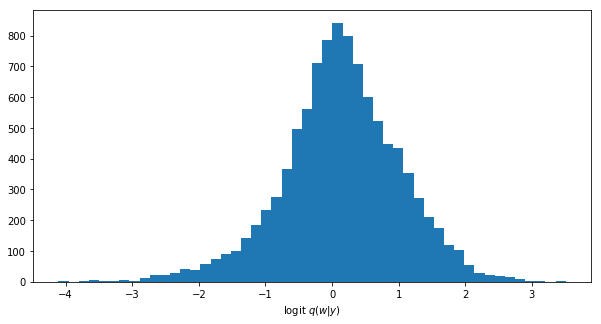

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(p, bins=50)
plt.xlabel("logit $q(w|y)$")
plt.show()

In [57]:
correct_pred = (p < 0.).float().mean()
print("Proportion of times we would have correctly predicted the outcome", correct_pred.item())

Proportion of times we would have correctly predicted the outcome 0.4237000048160553


Whilst we may not make the right call that often, we can see that the poll has given a significant amount of information.

## Conclusions

In this tutorial, we showed how optimal experimental design principles can be applied to electoral polling. Of course, our model could be improved in a number of ways: a useful guide to the kinds of models used in political science can be found in [3]. Our optimal design strategy will only ever be as good as our prior, so there is certainly a lot of use in investing time in choosing a good prior.

It might also be possible to search over the possible polling strategies in a more sophisticated way. For instance, simulated annealing [4] is one technique that can be used for optimization in high-dimensional discrete spaces.

Finally, our polling strategies were chosen with one objective in mind: predict the final outcome. If, on the other hand, we wanted to make more fine-grained predictions, we could use the same procedure but treat $\alpha$ as our target instead of $w$.

Overall, if we have the option of first design the polling strategy (or market research strategy, survey, etc.) using our prior, this can help lead to better predictions once we have collected our data.

## References

[1] Chaloner, K. and Verdinelli, I., 1995. **Bayesian experimental design: A review.** Statistical Science, pp.273-304.

[2] Foster, A., Jankowiak, M., Bingham, E., Horsfall, P., Teh, Y.W., Rainforth, T. and Goodman, N., 2019. **Variational Bayesian Optimal Experimental Design.** Advances in Neural Information Processing Systems 2019 (to appear).

[3] Gelman, A., Carlin, J.B., Stern, H.S., Dunson, D.B., Vehtari, A. and Rubin, D.B., 2013. **Bayesian data analysis.** Chapman and Hall/CRC.

[4] Kirkpatrick, S., Gelatt, C.D. and Vecchi, M.P., 1983. **Optimization by simulated annealing.** Science, 220(4598), pp.671-680.